In [77]:
from datetime import datetime
import pickle

import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error)
from xgboost import XGBRegressor

from scripts.data_processing import (
    load_uci, load_tidepool_dummy, 
    load_so_pump, 
    load_so_cgm)

In [78]:
def resample(df, freq='5Min', value_col='value'):
    """Converts measurements to a given interval"""
    df = df.copy()
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    desired_dts = pd.date_range(df['timestamp'].min().round(freq),
                                df['timestamp'].max().round(freq), 
                                freq=freq)
    
    interp = np.interp(desired_dts, df['timestamp'], df[value_col])
    
    df = pd.DataFrame({'timestamp':desired_dts,
                       value_col:interp})
    
    return df


def append_hour_day_features(df):
    df = df.copy()
    df = pd.concat(
        [df, 
         pd.get_dummies(df['timestamp'].dt.hour, prefix='hour_of_day'),
         pd.get_dummies(df['timestamp'].dt.weekday, prefix='day_of_week')], 
        axis=1
    )
    
    return df


def type_check(df):
    for col in ['timestamp', 'value', 'below_threshold']:
        assert pd.api.types.is_numeric_dtype(df[col])
    
    return None


def append_historical_cols(df, value_col='value', n_value_cols=12, 
                           n_rate_cols=0, interval_mins=5):
    """Adds recent blood glucose measures as columns"""
    df = df.copy()
    
    for x in range(1, max([n_value_cols, n_rate_cols])+1):
        if x <= n_value_cols:
            df[f'{value_col}_lag{str(x).zfill(2)}'] = df[value_col].shift(x)
        if x <= n_rate_cols:
            df[f'{value_col}_per_min_lag{str(x).zfill(2)}'] = (
                (df[value_col].shift(x-1) - df[value_col].shift(x)).divide(interval_mins)
            )

    return df


def append_future_target_col(df, minutes=30):
    """Append target column for machine learning model"""
    df = df.copy()

    target_name = f'future_value_{str(minutes).zfill(2)}_minutes'
    df[target_name] = df['value'].shift(int(-minutes/5))
    
    return df


def split_train_validate(df, minutes=30, test_fraction=0.2):
    df = df.copy()
    
    test_size = int(df.shape[0] * test_fraction)
    df_train = df.iloc[0:-test_size]
    df_val   = df.iloc[-test_size:]
    print(f'train size: {len(df_train)}')
    print(f'test size: {len(df_val)}')
    
    target_name = f'future_value_{str(minutes).zfill(2)}_minutes'
    X_train  = df_train.drop(columns=[target_name])
    y_train  = df_train[target_name]
    
    X_val    = df_val.drop(columns=[target_name])
    y_val    = df_val[target_name]
    
    return X_train, X_val, y_train, y_val


def build_model(df, minutes=30):
    df = append_historical_bg_cols(df.copy(), minutes)
    df = append_future_target_col(df.copy(), minutes)
    
    X_train, X_val, y_train, y_val = \
        split_train_validate(df.copy(), minutes=minutes)
    
    param_grid = {  
        'learning_rate': [0.05, 0.06, 0.07, 0.08],
        'n_estimators':  [40, 50, 60],
        'max_depth': [2],
    }

    gridsearch = GridSearchCV(XGBRegressor(),
                              param_grid=param_grid, 
                              # scoring='roc_auc', 
                              cv=3, n_jobs=-1,
                              return_train_score=True, verbose=10)
    gridsearch.fit(X_train, y_train)
    print('best estimator:', gridsearch.best_estimator_)
    print(gridsearch.cv_results_['mean_train_score'].mean(),
          gridsearch.cv_results_['mean_test_score'].mean())
    y_pred = gridsearch.predict(X_val)
    print('mae:', mean_absolute_error(y_val, y_pred))
    print('rmse:', np.sqrt(mean_squared_error(y_val, y_pred)))
    
    return gridsearch


def baseline_rmse(df, minutes=30):
    """Baseline RMSE assuming the target value will be the same
    as the current value
    """
    df = load_so_cgm()
    df = append_future_target_col(df.copy(), minutes)
    df = df.dropna()
    target_name = f'future_value_{str(minutes).zfill(2)}_minutes'
    mse = sum((df[target_name] - 
               df['value']).pow(2)) / len(df)
    
    return np.sqrt(mse)


def score(model, X_train, X_val, y_train, y_val):
    # train score
    mse = mean_squared_error(y_train, model.predict(X_train))
    rmse = np.sqrt(mse)
    print(rmse)
    
    # test score
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print(rmse)


def plot(df, model, duration_mins=30):
    """Plots a randomly selected portion of data"""
    df = df.copy()
    
    min_time = df.sample(1)['timestamp'].values[0]
    max_time = min_time + (duration_mins * 60)
    
    df = df.loc[(min_time <= df['timestamp']) & 
                (df['timestamp'] <= max_time)]

    # actual
    plt.plot(df['timestamp'], 
             df['value'], 
             color='b', marker='P')

    # prediction
    plt.plot(df['timestamp'] + 30 * 60, 
             model.predict(df), 
             color='g', marker='d')
    
    return plt.show()

### Naive Baseline RMSE

In [172]:
for minute in range(5, 31, 5):
    print(str(minute).zfill(2), 'minutes in future:',
          baseline_rmse(df=load_so_cgm(), minutes=minute))

05 minutes in future: 6.719252100307445
10 minutes in future: 10.41333712177528
15 minutes in future: 14.53977672402164
20 minutes in future: 18.158543769341655
25 minutes in future: 21.638654622552746
30 minutes in future: 24.896238216187268


## Model Selection

In [30]:
df = load_so_pump()

df = (df.set_index('Datetime')['Value']
        .resample('5Min').sum()
        .reset_index())
df['Datetime'] = df['Datetime'] + pd.Timedelta(minutes=5)
df = df.rename(columns={'Datetime':'timestamp',
                        'Value':'ins_prev5min'})
df = append_historical_cols(df, value_col='ins_prev5min')
df = df.dropna()

pmp = df.copy(); del df

In [31]:
df = load_so_cgm()
df = resample(df, freq='5Min')
df = append_historical_cols(df, value_col='value')
df = append_future_target_col(df)
df = df.dropna()

In [32]:
df = df.merge(pmp, on='timestamp')
# df = append_hour_day_features(df)
df['timestamp'] = df['timestamp'].astype(np.int64) // 10**9

### Linear Regression

In [82]:
X_train, X_val, y_train, y_val = (
    split_train_validate(df)
)

train size: 54460
test size: 13615


In [83]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [84]:
score(model, X_train, X_val, y_train, y_val)

16.53343625464301
21.504662370119526


In [87]:
pd.Series(model.coef_,
          X_train.columns).sort_values(ascending=False)

value                 3.190833e+00
ins_prev5min_lag02    1.211457e+00
ins_prev5min          1.210461e+00
ins_prev5min_lag01    1.188757e+00
ins_prev5min_lag03    9.113467e-01
ins_prev5min_lag04    3.243260e-01
ins_prev5min_lag05    5.526559e-02
value_lag04           4.166017e-02
value_lag12           2.810709e-02
value_lag11           2.537052e-02
value_lag09           1.773497e-02
value_lag07           9.016186e-03
timestamp             2.076113e-07
value_lag10          -9.137100e-04
value_lag06          -7.732042e-03
value_lag02          -3.694270e-02
value_lag08          -5.673124e-02
value_lag05          -5.735421e-02
ins_prev5min_lag06   -1.419397e-01
value_lag03          -1.679326e-01
ins_prev5min_lag07   -3.342750e-01
ins_prev5min_lag09   -4.348999e-01
ins_prev5min_lag10   -4.355934e-01
ins_prev5min_lag08   -4.805450e-01
ins_prev5min_lag12   -5.548265e-01
ins_prev5min_lag11   -5.711833e-01
value_lag01          -2.124752e+00
dtype: float64

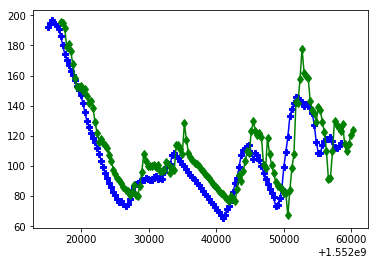

In [97]:
plot(X_val, model, duration_mins=12*60)

### Random Forest

In [33]:
X_train, X_val, y_train, y_val = (
    split_train_validate(df)
)

train size: 54460
test size: 13615


In [51]:
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_leaf=0.004,
    n_jobs=-1
)

In [52]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.004, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
# feature importances
pd.Series(model.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

value                 0.940081
value_lag04           0.015955
value_lag03           0.015888
value_lag05           0.010383
value_lag02           0.007952
value_lag06           0.005596
value_lag07           0.001765
value_lag01           0.000874
value_lag08           0.000487
timestamp             0.000391
value_lag12           0.000158
value_lag09           0.000115
value_lag11           0.000089
value_lag10           0.000082
ins_prev5min_lag12    0.000030
ins_prev5min_lag05    0.000028
ins_prev5min          0.000027
ins_prev5min_lag06    0.000018
ins_prev5min_lag03    0.000014
ins_prev5min_lag01    0.000012
ins_prev5min_lag04    0.000012
ins_prev5min_lag02    0.000010
ins_prev5min_lag09    0.000010
ins_prev5min_lag11    0.000009
ins_prev5min_lag08    0.000006
ins_prev5min_lag10    0.000005
ins_prev5min_lag07    0.000003
dtype: float64

In [56]:
# permutation feature importances
permuter = PermutationImportance(model, scoring='neg_mean_squared_error', n_iter=1, cv='prefit')
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.004, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True,
           scoring='neg_mean_squared_error')

In [57]:
eli5.show_weights(permuter, top=None, feature_names=X_train.columns.tolist())

Weight,Feature
4179.5079 ± 0.0000,value
39.6248 ± 0.0000,value_lag03
36.5089 ± 0.0000,value_lag04
19.0717 ± 0.0000,value_lag05
17.4247 ± 0.0000,value_lag02
6.0132 ± 0.0000,value_lag06
1.5626 ± 0.0000,value_lag01
1.2389 ± 0.0000,value_lag07
0.9742 ± 0.0000,timestamp
0.4622 ± 0.0000,value_lag12


### Gradient Boosting Regressor

In [79]:
X_train, X_val, y_train, y_val = (
    split_train_validate(df)
)

train size: 54460
test size: 13615


In [80]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [81]:
score(model, X_train, X_val, y_train, y_val)

16.73303164984469
22.60373950838316


## Write Models

In [ ]:
df = load_so_cgm()
models = []
for minutes in range(5, 31, 5):
    with open('diabetesmanager/ml_models/model_' + str(minutes) + '_minutes.pkl', 'wb') as f:
        model = build_model(df.copy(), minutes)
        pickle.dump(model, f)
        models.append(model)

## Read Models

In [ ]:
from pathlib import Path

MODEL_DIR = Path('diabetesmanager/ml_models')
models = []
for model_path in MODEL_DIR.iterdir():
    if str(model_path).endswith('.pkl'):
        with open(model_path, 'rb') as f:
            models.append(pickle.load(f))